In [1]:
print("Installing some dependencies...")
%pip install gdown
%pip install SimpleITK
print("Done!")

Installing some dependencies...
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Done!


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from skimage.restoration import denoise_nl_means, estimate_sigma
from scipy.spatial.distance import directed_hausdorff
import re
from pathlib import Path  # Import pathlib for path handling
import gdown
import zipfile

In [3]:
# See tensorflow version
print(tf.__version__)

2.10.0


In [4]:
main_path = Path.cwd()  # Get the current working directory

if not os.path.exists(main_path / 'datasets'):
    
    # Download the dataset (zip)

    url = 'https://drive.google.com/file/d/17fKi5QYROdVoUjmzC90TCe_Tal9hNPph/view?usp=sharing'

    output = 'dataset.zip'

    gdown.download(url, output, quiet=False, fuzzy=True)

    # Unzip the dataset

    print('Unzipping the dataset...')
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall('.')

    print('Dataset unzipped successfully!')
else:
    print('Dataset already exists!')

Dataset already exists!


In [5]:
# Configuration
BASE_SEGMENTATION_DIR = Path("datasets/segmentation/PROSTATEx")      # Directory containing segmentation masks
BASE_IMAGES_DIR = Path("datasets/segmentation2/PROSTATEx")          # Directory containing image slices

SEGMENTATION_FILENAME = "1-1.dcm"                                         # Segmentation mask filename per patient
IMAGE_FILENAME_PATTERN = r".*\.dcm$"                                      # Pattern to match image slices

IMG_HEIGHT, IMG_WIDTH = 256, 256                                          # Desired image height and width after resizing
TARGET_DEPTH = 16                                                # Fixed number of slices per volume
BATCH_SIZE = 2                                                           # Adjust based on GPU memory
EPOCHS = 100

In [6]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

def pad_or_crop_volume(volume, target_depth):
    current_depth = volume.shape[0]
    if current_depth == target_depth:
        return volume
    elif current_depth > target_depth:
        # Crop center
        start = (current_depth - target_depth) // 2
        end = start + target_depth
        return volume[start:end]
    else:
        # Pad with zeros at both ends if needed
        diff = target_depth - current_depth
        pad_before = diff // 2
        pad_after = diff - pad_before
        padding = ((pad_before, pad_after), (0,0), (0,0))
        return np.pad(volume, padding, mode='constant', constant_values=0)

def load_sitk_volume_from_directory(directory, filename_pattern=None):
    """
    Load a DICOM series from a directory using SimpleITK and return as a NumPy array.
    If filename_pattern is given, filter the files. Otherwise, load all DICOM files in the directory.
    
    Returns None if no valid DICOM series found.
    """
    reader = sitk.ImageSeriesReader()
    if filename_pattern:
        # Filter files according to pattern
        all_files = [os.path.join(directory, f) for f in os.listdir(directory)]
        filtered_files = [f for f in all_files if re.match(filename_pattern, os.path.basename(f))]
        if len(filtered_files) == 0:
            return None
        reader.SetFileNames(filtered_files)
    else:
        # Use GetGDCMSeriesFileNames to automatically find the series
        dicom_files = reader.GetGDCMSeriesFileNames(directory)
        if len(dicom_files) == 0:
            return None
        reader.SetFileNames(dicom_files)
    
    image = reader.Execute()
    image_array = sitk.GetArrayFromImage(image)  # shape: (depth, height, width)
    return image_array

def load_sitk_image(filepath):
    """
    Load a single DICOM file or other image file directly with SimpleITK and return as numpy array.
    This is for masks that are a single DICOM (not a series).
    If the mask is multi-slice, it might still load as a volume.
    """
    if not os.path.exists(filepath):
        return None
    image = sitk.ReadImage(str(filepath))
    image_array = sitk.GetArrayFromImage(image)  # (depth, height, width) or (height, width) if single slice
    return image_array

def load_dataset(segmentation_dir, images_dir, segmentation_filename, img_height, img_width, target_depth):
    """
    Load images and masks from separate directories using SimpleITK,
    preprocess them, pad/crop to a fixed depth, and return as numpy arrays.
    
    Parameters:
    - segmentation_dir: Directory containing segmentation masks (one per patient).
    - images_dir: Directory containing image slices in DICOM format (multiple per patient).
    - segmentation_filename: Filename of the segmentation mask per patient.
    - img_height: Desired image height after resizing.
    - img_width: Desired image width after resizing.
    - target_depth: Fixed number of slices per volume.
    
    Returns:
    - images: Numpy array (num_patients, target_depth, img_height, img_width)
    - masks: Numpy array (num_patients, target_depth, img_height, img_width)
    """
    images = []
    masks = []
    
    IMAGE_FILENAME_PATTERN = r".*\.dcm$"  # example: load only files ending with .dcm
    
    # List of patients based on segmentation directory
    patients = [p for p in segmentation_dir.iterdir() if p.is_dir()]

    print(f"Found {len(patients)} patients")
    
    for patient_dir in patients:
        patient = patient_dir.name
        mask_path = patient_dir / segmentation_filename
        if not mask_path.exists():
            print(f"Segmentation mask not found for patient: {patient}")
            continue
        
        # Load segmentation mask using SimpleITK
        mask_volume = load_sitk_image(mask_path)
        if mask_volume is None:
            print(f"Failed to load mask for patient: {patient}")
            continue
        
        # Ensure mask_volume is 3D
        if mask_volume.ndim == 2:
            mask_volume = np.expand_dims(mask_volume, axis=0)  # (1, H, W)
        
        # Path to image directory
        patient_img_dir = os.path.join(images_dir, patient)
        if not os.path.exists(patient_img_dir):
            print(f"Image directory not found for patient: {patient}")
            continue
        
        # Load image volume
        img_volume = load_sitk_volume_from_directory(patient_img_dir, IMAGE_FILENAME_PATTERN)
        if img_volume is None or len(img_volume) == 0:
            print(f"No image slices found for patient: {patient}")
            continue
        
        # Pad or crop volumes to target_depth
        img_volume = pad_or_crop_volume(img_volume, target_depth)
        mask_volume = pad_or_crop_volume(mask_volume, target_depth)
        
        # Resize each slice to desired dimensions
        img_volume_resized = []
        mask_volume_resized = []
        depth = img_volume.shape[0]
        for i in range(depth):
            slice_img = img_volume[i]
            slice_mask = mask_volume[i]
            
            # Resize image and mask
            slice_img = cv2.resize(slice_img, (img_width, img_height), interpolation=cv2.INTER_LINEAR)
            slice_mask = cv2.resize(slice_mask, (img_width, img_height), interpolation=cv2.INTER_NEAREST)
            
            img_volume_resized.append(slice_img)
            mask_volume_resized.append(slice_mask)
        
        img_volume_resized = np.array(img_volume_resized)
        mask_volume_resized = np.array(mask_volume_resized)
        
        # Ensure masks are binary
        mask_volume_resized = (mask_volume_resized > 0.5).astype(np.uint8)
        
        images.append(img_volume_resized)
        masks.append(mask_volume_resized)
        
        print(f"Processed patient: {patient}")
    
    images = np.array(images)  # (num_patients, target_depth, img_height, img_width)
    masks = np.array(masks)    # (num_patients, target_depth, img_height, img_width)
    
    return images, masks

In [7]:
# Load the dataset
images, masks = load_dataset(
    segmentation_dir=BASE_SEGMENTATION_DIR,
    images_dir=BASE_IMAGES_DIR,
    segmentation_filename=SEGMENTATION_FILENAME,
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
    target_depth=TARGET_DEPTH
)

print(f"Loaded {images.shape[0]} patients.")
print(f"Image shape: {images.shape}")  # Expected: (num_patients, depth=19, height=256, width=256)
print(f"Mask shape: {masks.shape}")    # Expected: (num_patients, depth=19, height=256, width=256)")

Found 66 patients
Processed patient: ProstateX-0004
Processed patient: ProstateX-0007
Processed patient: ProstateX-0009
Processed patient: ProstateX-0015
Processed patient: ProstateX-0020
Processed patient: ProstateX-0026
Processed patient: ProstateX-0046
Processed patient: ProstateX-0054
Processed patient: ProstateX-0056
Processed patient: ProstateX-0065
Processed patient: ProstateX-0066
Processed patient: ProstateX-0069
Processed patient: ProstateX-0070
Processed patient: ProstateX-0072
Processed patient: ProstateX-0076
Processed patient: ProstateX-0083
Processed patient: ProstateX-0084
Processed patient: ProstateX-0089
Processed patient: ProstateX-0090
Processed patient: ProstateX-0094
Processed patient: ProstateX-0096
Processed patient: ProstateX-0102
Processed patient: ProstateX-0111
Processed patient: ProstateX-0112
Processed patient: ProstateX-0117
Processed patient: ProstateX-0118
Processed patient: ProstateX-0121
Processed patient: ProstateX-0125
Processed patient: ProstateX-0

In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

Training set: (52, 16, 256, 256), (52, 16, 256, 256)
Validation set: (14, 16, 256, 256), (14, 16, 256, 256)


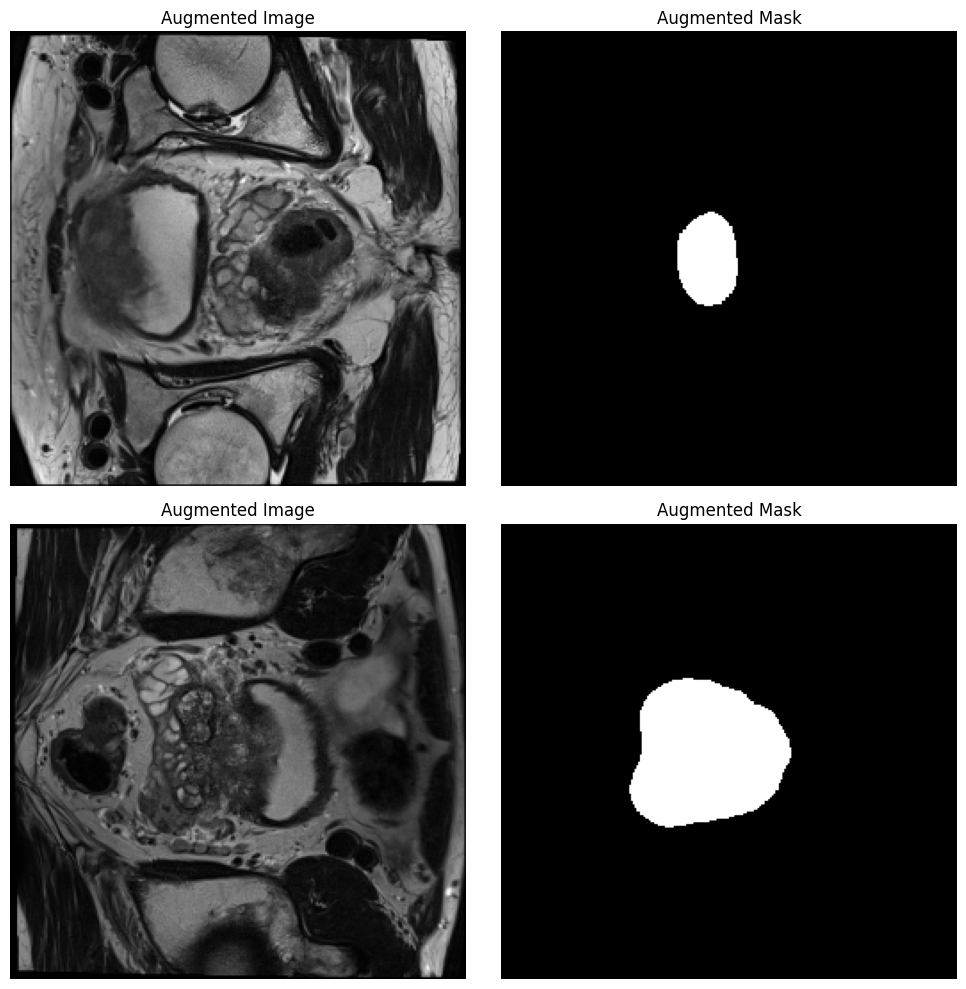

In [9]:
import numpy as np

def random_flip_3d(volume, mask):
    """
    Randomly flip the volume and mask along the horizontal and/or vertical axes.
    
    Parameters:
    - volume: 3D numpy array with shape (depth, height, width).
    - mask: 3D numpy array with shape (depth, height, width).
    
    Returns:
    - volume_flipped: 3D numpy array.
    - mask_flipped: 3D numpy array.
    """
    # Flip along the width axis (axis=2)
    if np.random.rand() < 0.5:
        volume = np.flip(volume, axis=2)
        mask = np.flip(mask, axis=2)
    
    # Flip along the height axis (axis=1)
    if np.random.rand() < 0.5:
        volume = np.flip(volume, axis=1)
        mask = np.flip(mask, axis=1)
    
    return volume, mask

def random_rotate_3d(volume, mask):
    """
    Randomly rotate the volume and mask by 90 degrees around the depth axis.
    
    Parameters:
    - volume: 3D numpy array with shape (depth, height, width).
    - mask: 3D numpy array with shape (depth, height, width).
    
    Returns:
    - volume_rotated: 3D numpy array.
    - mask_rotated: 3D numpy array.
    """
    k = np.random.choice([0, 1, 2, 3])
    volume = np.rot90(volume, k, axes=(1, 2))
    mask = np.rot90(mask, k, axes=(1, 2))
    return volume, mask

def augment_data_3d(volume, mask):
    """
    Apply a series of random 3D augmentations to the volume and mask.
    
    Parameters:
    - volume: 3D numpy array with shape (depth, height, width).
    - mask: 3D numpy array with shape (depth, height, width).
    
    Returns:
    - volume_augmented: 3D numpy array.
    - mask_augmented: 3D numpy array.
    """
    volume, mask = random_flip_3d(volume, mask)
    volume, mask = random_rotate_3d(volume, mask)
    # No scaling or resampling is performed now
    return volume, mask

def data_generator_3d(X, Y, batch_size, img_height, img_width):
    """
    Generate batches of augmented 3D data.
    
    Parameters:
    - X: Numpy array of image volumes (num_patients, depth, height, width).
    - Y: Numpy array of mask volumes (num_patients, depth, height, width).
    - batch_size: Number of samples per batch.
    - img_height: Image height (if needed for resizing outside this function).
    - img_width: Image width (if needed for resizing outside this function).
    
    Yields:
    - A tuple (batch_imgs, batch_masks) where:
      batch_imgs: (batch_size, depth, height, width, 1)
      batch_masks: (batch_size, depth, height, width, 1)
    """
    num_samples = X.shape[0]
    while True:
        idxs = np.random.permutation(num_samples)
        for i in range(0, num_samples, batch_size):
            batch_idxs = idxs[i:i + batch_size]
            batch_imgs = []
            batch_masks = []
            for idx in batch_idxs:
                img, mask = X[idx], Y[idx]
                img, mask = augment_data_3d(img, mask)
                img = np.expand_dims(img, axis=-1)   # Shape: (depth, height, width, 1)
                mask = np.expand_dims(mask, axis=-1) # Shape: (depth, height, width, 1)
                batch_imgs.append(img)
                batch_masks.append(mask)
            yield np.array(batch_imgs), np.array(batch_masks)

# Example usage:
train_gen = data_generator_3d(X_train, y_train, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH)
val_gen = data_generator_3d(X_val, y_val, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH)

# Visualize a few augmented samples
augmented_samples = next(train_gen)
augmented_images, augmented_masks = augmented_samples

# Get the actual batch size
batch_size = augmented_images.shape[0]
num_samples_to_show = min(4, batch_size)  # Show up to 4 samples, or less if batch is smaller

plt.figure(figsize=(10, 10))
for i in range(num_samples_to_show):
    plt.subplot(num_samples_to_show, 2, 2*i+1)
    plt.imshow(augmented_images[i][0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.title("Augmented Image")
    
    plt.subplot(num_samples_to_show, 2, 2*i+2)
    plt.imshow(augmented_masks[i][0, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.title("Augmented Mask")

plt.tight_layout()
plt.show()

In [10]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras as keras

def conv_block_3d(x, filters):
    x = layers.Conv3D(filters, (3, 3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv3D(filters, (3, 3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def build_3d_unet(input_shape=(TARGET_DEPTH, IMG_HEIGHT, IMG_WIDTH, 1)):
    inputs = keras.Input(shape=input_shape)
    
    # Encoder
    c1 = conv_block_3d(inputs, 32)
    p1 = layers.MaxPooling3D((2, 2, 2))(c1)
    
    c2 = conv_block_3d(p1, 64)
    p2 = layers.MaxPooling3D((2, 2, 2))(c2)
    
    c3 = conv_block_3d(p2, 128)
    p3 = layers.MaxPooling3D((2, 2, 2))(c3)
    
    # Bottleneck
    c4 = conv_block_3d(p3, 256)
    
    # Decoder
    u5 = layers.Conv3DTranspose(128, (2,2,2), strides=(2,2,2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = conv_block_3d(u5, 128)
    
    u6 = layers.Conv3DTranspose(64, (2,2,2), strides=(2,2,2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = conv_block_3d(u6, 64)
    
    u7 = layers.Conv3DTranspose(32, (2,2,2), strides=(2,2,2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = conv_block_3d(u7, 32)
    
    outputs = layers.Conv3D(1, (1, 1, 1), activation='sigmoid')(c7)
    model = keras.Model(inputs, outputs)
    return model


# Example usage
model = build_3d_unet()
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 256, 25  0           []                               
                                6, 1)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 16, 256, 256  896         ['input_1[0][0]']                
                                , 32)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 256, 256  128        ['conv3d[0][0]']                 
 alization)                     , 32)                                                         

In [28]:
from tensorflow.keras.models import load_model

# Calculate steps per epoch
steps_per_epoch = len(X_train) // BATCH_SIZE
validation_steps = len(X_val) // BATCH_SIZE

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "prostate_segmentation_best.keras", 
        save_best_only=True, 
        monitor='val_loss',
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        verbose=1
    )
]

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=callbacks
)

model = load_model("prostate_segmentation_best.keras")

model.save("prostate_segmentation_model.h5")

In [11]:
def dice_coefficient_np(y_true, y_pred):
    """
    Compute Dice Similarity Coefficient.
    
    Parameters:
    - y_true: Ground truth mask (3D numpy array).
    - y_pred: Predicted mask (3D numpy array).
    
    Returns:
    - Dice coefficient.
    """
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1e-8)

def hausdorff_distance_np(y_true, y_pred):
    """
    Compute Hausdorff Distance between two binary masks.
    
    Parameters:
    - y_true: Ground truth mask (3D numpy array).
    - y_pred: Predicted mask (3D numpy array).
    
    Returns:
    - Hausdorff distance.
    """
    y_true_pts = np.argwhere(y_true)
    y_pred_pts = np.argwhere(y_pred)
    
    if len(y_true_pts) == 0 or len(y_pred_pts) == 0:
        return np.inf
    
    forward_hd = directed_hausdorff(y_true_pts, y_pred_pts)[0]
    backward_hd = directed_hausdorff(y_pred_pts, y_true_pts)[0]
    
    return max(forward_hd, backward_hd)

7/7 [==============================] - 27s 4s/step
Prediction stats:
Min: 0.0004881002
Max: 0.9987971
Mean: 0.118868425
Std: 0.058646373
Mean Dice Coefficient on Validation Set: 0.1144
Mean Hausdorff Distance on Validation Set: inf mm


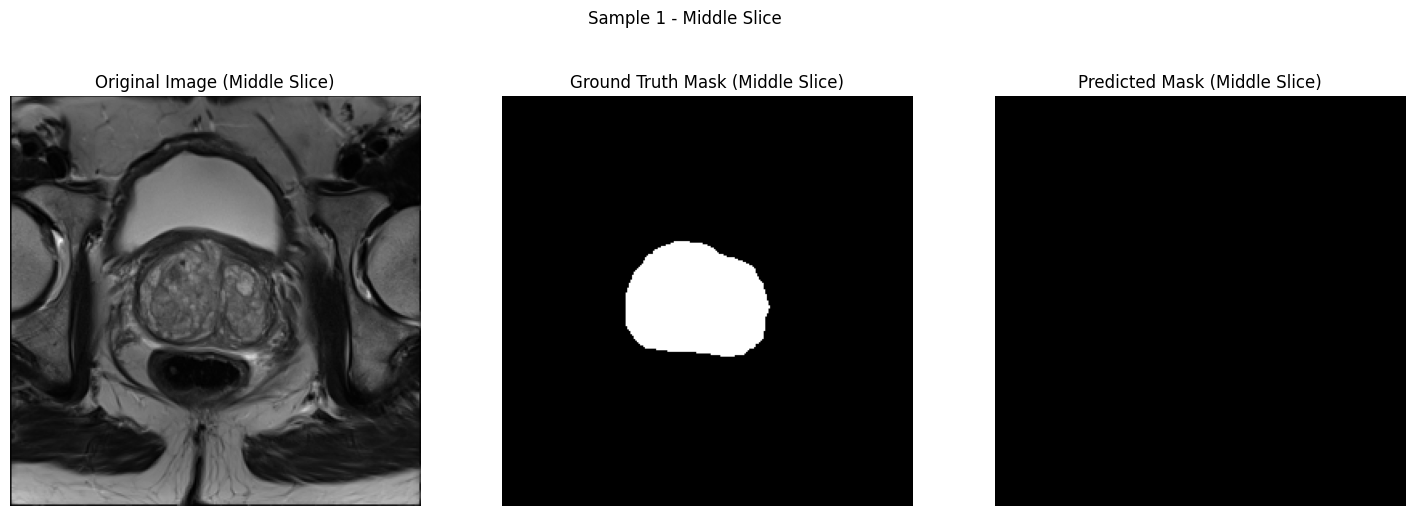

In [12]:
import h5py
from tensorflow.python.keras.saving.hdf5_format import load_weights_from_hdf5_group

def visualize_prediction_3d(image_volume, ground_truth_volume, prediction_volume, idx):
    """
    Display the middle slice of the 3D volume: original image, ground truth mask, and predicted mask.
    
    Parameters:
    - image_volume: 3D numpy array (depth, height, width).
    - ground_truth_volume: 3D numpy array (depth, height, width).
    - prediction_volume: 3D numpy array (depth, height, width).
    - idx: Index of the sample.
    """
    mid_slice = TARGET_DEPTH // 2
    
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image_volume[mid_slice], cmap='gray')
    plt.title('Original Image (Middle Slice)')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(ground_truth_volume[mid_slice], cmap='gray')
    plt.title('Ground Truth Mask (Middle Slice)')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(prediction_volume[mid_slice], cmap='gray')
    plt.title('Predicted Mask (Middle Slice)')
    plt.axis('off')
    
    plt.suptitle(f"Sample {idx} - Middle Slice")
    plt.show()

# Load the entire model (ensure the filename matches how you saved it)
model = build_3d_unet()
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

with h5py.File('prostate_segmentation.h5', 'r') as f:
    load_weights_from_hdf5_group(f['model_weights'], model.layers)

# Predict on the validation set with reduced batch size to prevent OOM
val_predictions = model.predict(X_val, batch_size=2)

# Check prediction statistics
print("Prediction stats:")
print("Min:", np.min(val_predictions))
print("Max:", np.max(val_predictions))
print("Mean:", np.mean(val_predictions))
print("Std:", np.std(val_predictions))

# Binarize predictions with threshold=0.5
val_predictions_bin = (val_predictions > 0.5).astype(np.uint8)

# Compute metrics
dice_scores = []
hausdorff_scores = []

for i in range(len(y_val)):
    dice = dice_coefficient_np(y_val[i], val_predictions_bin[i, :, :, :, 0])
    hd = hausdorff_distance_np(y_val[i], val_predictions_bin[i, :, :, :, 0])
    dice_scores.append(dice)
    hausdorff_scores.append(hd)

print(f"Mean Dice Coefficient on Validation Set: {np.mean(dice_scores):.4f}")
print(f"Mean Hausdorff Distance on Validation Set: {np.mean(hausdorff_scores):.4f} mm")

# Visualize the first validation sample
visualize_prediction_3d(
    X_val[0],
    y_val[0],
    val_predictions_bin[0, :, :, :, 0],
    idx=1
)

In [ ]:
# Check if there are any positive labels in the first validation mask
print("Sum of ground truth mask:", np.sum(y_val[0]))


In [32]:
# Save the model
model.save("prostate_segmentation.keras")
print("Model saved as prostate_segmentation.keras")

In [31]:
# Plot training & validation loss and accuracy values
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='green')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', color='red')
plt.title('Model Accuracy Over Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [ ]:
%cd /kaggle/working
 
from IPython.display import FileLink

FileLink(r'prostate_segmentation.keras')